In [3]:
import torch
import torchvision
import time
import random
import math
import json

from operator import add
from PIL import Image, ImageFont, ImageDraw

In [4]:
im = Image.open('./Test_Pictures/A_rhodesian-ridgeback.jpg')
To_Tensor = torchvision.transforms.ToTensor()
tensor_dog = To_Tensor(im).unsqueeze(0)
print(tensor_dog.shape)

torch.Size([1, 3, 619, 1100])


In [5]:
"""
model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(
    weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT,
    box_detections_per_img=100
)
model.train()
"""

'\nmodel = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(\n    weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT,\n    box_detections_per_img=100\n)\nmodel.train()\n'

In [6]:
#print(model.cpu()(tensor_dog))
#print(model.cpu()(tensor_dog,[{'boxes':torch.FloatTensor([[0,0,10,10]]), 'labels':torch.zeros(1).long()}]))

In [7]:

targets_test = [
    {'boxes':torch.FloatTensor([[0,0],[0,0]]), 'labels':torch.LongTensor([1,0,0,0])}
]

In [8]:
texturesList = [Image.open('./Textures/parchment-bg-filter.png')]

In [9]:
alphabet = ['*','A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
random.seed(100)
alphabetColors = [(random.randrange(256),random.randrange(256),random.randrange(256)) for i in alphabet]
def displayCoords(image, coords, labels):
    font = ImageFont.truetype("meiryo.ttc", 20)
    imageCopy = image.copy()
    draw = ImageDraw.Draw(imageCopy)
    for i in range(len(coords)):
        coord = coords[i]
        label = labels[i]
        x1 = coord[0]
        y1 = coord[1]
        x2 = coord[2]
        y2 = coord[3]
        color = alphabetColors[label]
        
        draw.rectangle([x1,y1,x2,y2], outline=color, width=2)
        draw.text((x1+2,y1), alphabet[label], color, font=font)
        
    display(imageCopy)

In [10]:
def rotateBox(box:list, angle:float, center:tuple) -> list:
    angleRad = math.pi*angle/180
    
    x1,y1,x2,y2 = box
    x1=x1-center[0]
    x2=x2-center[0]
    y1=-(y1-center[1])
    y2=-(y2-center[1])
    
    
    cos=math.cos(angleRad)
    sin=math.sin(angleRad)
    newXs = [
        x1*cos-y1*sin,
        x2*cos-y1*sin,
        x1*cos-y2*sin,
        x2*cos-y2*sin
    ]
    
    newYs = [
        -(x1*sin+y1*cos),
        -(x2*sin+y1*cos),
        -(x1*sin+y2*cos),
        -(x2*sin+y2*cos)
    ]
    """
    tl = (x1*cos-y1*sin, x1*sin+y1*cos)
    tr = (x2*cos-y1*sin, x2*sin+y1*cos)
    bl = (x1*cos-y2*sin, x1*sin+y2*cos)
    br = (x2*cos-y2*sin, x2*sin+y2*cos)
    """
    return [int(min(newXs)+center[0]), int(min(newYs)+center[1]), int(max(newXs)+center[0]), int(max(newYs)+center[1])]
    
    

In [11]:
def createImage(pixelSize=(600,600), labels=[], nPerturbs=5, font=None, yBaseOffset=0,angle=0,seed=0) -> Image:
    random.seed(seed)
    
    info = {'boxes' : [], 'labels' : []}
    padding = 0
    
    foreground=(random.randrange(256),random.randrange(256),random.randrange(256), 255)
    background=(random.randrange(256),random.randrange(256),random.randrange(256))
    """
    distance = abs(foreground[0]+foreground[1]+foreground[2]-background[0]-background[1]-background[2])
    modif = 255//(distance+1)
    background=(background[0]*modif,background[1]*modif,background[2]*modif)
    """
    distance = (foreground[0]+foreground[1]+foreground[2]-background[0]-background[1]-background[2])
    signDist = int(math.copysign(1,distance))
    modif = 10*255//(distance+signDist)
    background=(background[0]-modif,background[1]-modif,background[2]-modif)
    foreground=(foreground[0]+modif,foreground[1]+modif,foreground[2]+modif, 255)
    
    baseFontSize = font.size
    
    image1 = Image.new(mode='RGBA', size=pixelSize, color=(255,255,255,0))
    draw1 = ImageDraw.Draw(image1)
    
    perturb_font = ImageFont.truetype("yumin.ttf", baseFontSize)
    perturb_foreground=(random.randrange(256),random.randrange(256),random.randrange(256), 255)
    perturbs = [alphabet[random.randrange(len(alphabet)+1)-1] for i in range(nPerturbs)]
    
    #Draw perturbations
    for perturb in perturbs:
        x0,y0,width,height = perturb_font.getbbox(perturb)
        
        fontSize = baseFontSize
        randXOffset = random.randrange(pixelSize[0] - fontSize)
        randYOffset = random.randrange(pixelSize[1] - fontSize)
        fontOffsetX = randXOffset
        fontOffsetY = yBaseOffset*fontSize + randYOffset
        draw1.text((fontOffsetX,fontOffsetY), perturb, perturb_foreground, font=perturb_font)
        info['boxes'].append([
            randXOffset-padding, 
            fontOffsetY-padding, 
            randXOffset+width+padding, 
            fontOffsetY+height+padding
        ])
        info['labels'].append(0) #0 is for background
    
    #Draw Glyphs
    for label in labels:
        symbol = alphabet[label+1]
        x0,y0,width,height = font.getbbox(symbol)
        
        fontSize = baseFontSize
        randXOffset = random.randrange(pixelSize[0] - fontSize)
        randYOffset = random.randrange(pixelSize[1] - fontSize)
        fontOffsetX = randXOffset
        fontOffsetY = yBaseOffset*fontSize + randYOffset
        draw1.text((fontOffsetX,fontOffsetY), symbol, foreground, font=font)
        info['boxes'].append([
            randXOffset-padding, 
            fontOffsetY-padding, 
            randXOffset+width+padding, 
            fontOffsetY+height+padding
        ])
        info['labels'].append(label+1) #0 is for background
    
    sampling = Image.Resampling.BICUBIC
    text_rot = image1.copy().rotate(angle,sampling,expand=True)
    
    
    backgroundPic = Image.new(mode='RGB', size=text_rot.size, color=background)
    
    #prepare texture for use in background
    texture = texturesList[random.randrange(len(texturesList))]
    pos_texture = (random.randrange(-texture.size[0],pixelSize[0]) , random.randrange(-texture.size[1],pixelSize[1]))
    backgroundPic.paste(texture,pos_texture,texture.split()[-1])
    
    image_rot = backgroundPic.copy()
    image_rot.paste(text_rot, (0, 0), text_rot.split()[-1])
    
    #update coords after rotation
    dx = (text_rot.size[0]-image1.size[0])/2
    dy = (text_rot.size[1]-image1.size[1])/2
    dV = [dx,dy,dx,dy]
    #print(info['boxes'])
    info['boxes'] = [list(map(add, boxes, dV)) for boxes in info['boxes']] # add the differences of size due to the rotation
    info['boxes'] = [rotateBox(boxes,angle,(text_rot.size[0]/2,text_rot.size[1]/2)) for boxes in info['boxes']]
    #print(info['boxes'])
    return image_rot, info

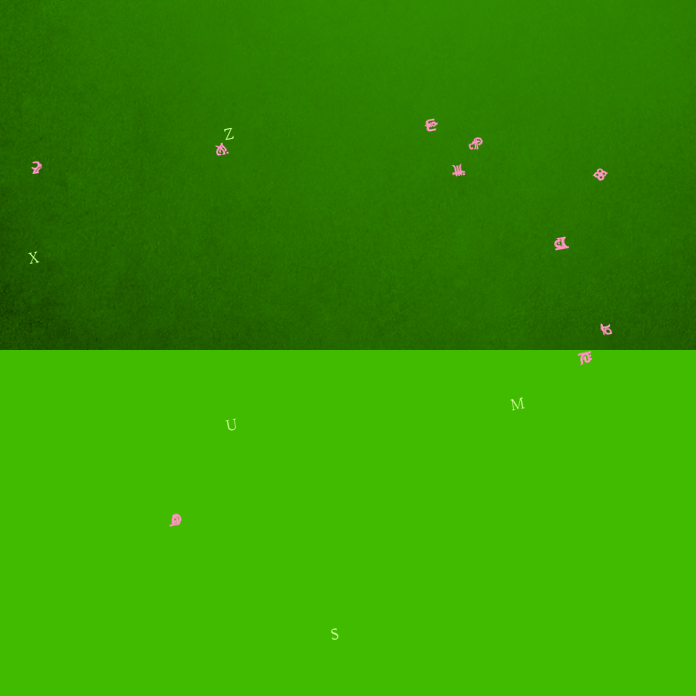

In [12]:
img_test,_ = createImage(
    labels=[0,1,2,3,4,5,6,7,8,9],
    nPerturbs=5,
    font=ImageFont.truetype("./Fonts/SoulGlyph.ttf", 15),
    yBaseOffset=0.0,
    angle=10.0,
    seed=12
)

display(img_test)

#img_test.save("./Test_Pictures/Test1.jpeg")

In [26]:
alphaSpace = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z',' ',' ',' ',' ',' ']
def createWordImage(pixelSize=(600,600), nPerturbs=5, font=None, yBaseOffset=0,angle=0,seed=0) -> Image:
    random.seed(seed)
    
    info = {'boxes' : [], 'labels' : []}
    padding = 0
    
    foreground=(random.randrange(256),random.randrange(256),random.randrange(256), 255)
    background=(random.randrange(256),random.randrange(256),random.randrange(256))
    
    """
    distance = abs(foreground[0]+foreground[1]+foreground[2]-background[0]-background[1]-background[2])
    modif = 255//(distance+1)
    background=(background[0]*modif,background[1]*modif,background[2]*modif)
    """
    distance = (foreground[0]+foreground[1]+foreground[2]-background[0]-background[1]-background[2])
    signDist = int(math.copysign(1,distance))
    modif = 10*255//(distance+signDist)
    background=(background[0]-modif,background[1]-modif,background[2]-modif)
    foreground=(foreground[0]+modif,foreground[1]+modif,foreground[2]+modif, 255)
    
    baseFontSize = font.size
    
    image1 = Image.new(mode='RGBA', size=pixelSize, color=(255,255,255,0))
    
    draw1 = ImageDraw.Draw(image1)
    
    
    perturb_font = ImageFont.truetype("yumin.ttf", baseFontSize)
    perturb_foreground=(random.randrange(256),random.randrange(256),random.randrange(256), 255)
    perturbs = [alphabet[random.randrange(len(alphabet))] for i in range(nPerturbs)]
    """
    #Draw perturbations
    for perturb in perturbs:
        x0,y0,width,height = perturb_font.getbbox(perturb)
        
        fontSize = baseFontSize
        randXOffset = random.randrange(pixelSize[0] - fontSize)
        randYOffset = random.randrange(pixelSize[1] - fontSize)
        fontOffsetX = randXOffset
        fontOffsetY = yBaseOffset*fontSize + randYOffset
        draw1.text((fontOffsetX,fontOffsetY), perturb, perturb_foreground, font=perturb_font)
    """
    
    #Draw Glyphs
    nx = (pixelSize[0]-2*padding)//baseFontSize
    ny = (pixelSize[1]-2*padding)//baseFontSize
    
    y=padding
    maxLabel=26 #Make sure that the first symbol is not a space
    for j in range(ny):
        x=padding
        for i in range(nx):
            label = random.randrange(maxLabel)
            symbol = alphaSpace[label]
            
            x0,y0,width,height = font.getbbox(symbol)
        
            fontSize = baseFontSize
            
            fontOffsetY = yBaseOffset*fontSize
            draw1.text((x,y+fontOffsetY), symbol, foreground, font=font)
            
            if label+1 < len(alphabet):
                info['boxes'].append([
                    x-padding, 
                    y-padding, 
                    x+width+padding, 
                    y+height+padding
                ])
                info['labels'].append(label+1) #0 is for background
            
            maxLabel = len(alphaSpace)
            x+=width
        y+=fontSize
    
    sampling = Image.Resampling.BICUBIC
    text_rot = image1.rotate(angle,sampling,expand=True)
    
    backgroundPic = Image.new(mode='RGB', size=text_rot.size, color=background)
    
    #prepare texture for use in background
    texture = texturesList[random.randrange(len(texturesList))]
    pos_texture = (random.randrange(-texture.size[0],pixelSize[0]) , random.randrange(-texture.size[1],pixelSize[1]))
    backgroundPic.paste(texture,pos_texture,texture.split()[-1])
    
    #update coords after rotation
    dx = (text_rot.size[0]-image1.size[0])/2
    dy = (text_rot.size[1]-image1.size[1])/2
    dV = [dx,dy,dx,dy]
    info['boxes'] = [list(map(add, boxes, dV)) for boxes in info['boxes']] # add the differences of size due to the rotation
    info['boxes'] = [rotateBox(boxes,angle,(text_rot.size[0]/2,text_rot.size[1]/2)) for boxes in info['boxes']]
    
    image_rot = backgroundPic.copy()
    image_rot.paste(text_rot, (0, 0), text_rot.split()[-1])
    
    #image_rot.show()
    return image_rot, info

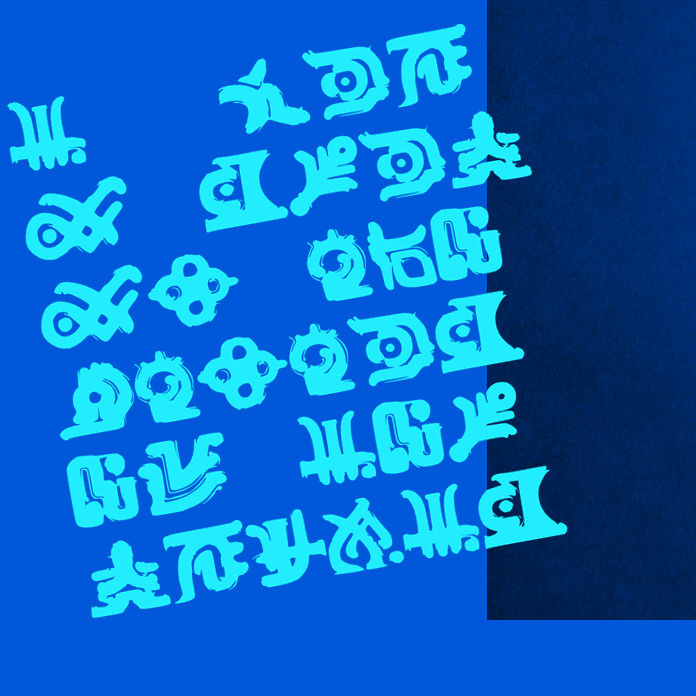

In [27]:
img_test2,_ = createWordImage(
    nPerturbs=5,
    font=ImageFont.truetype("./Fonts/SoulGlyph.ttf", 90),
    yBaseOffset=0.0,
    angle=10.0,
    seed=10
)

display(img_test2)

In [28]:
def createTrainingSet():
    
    start = time.time()
    nb_images = 2000
    list_info = []
    for i in range(nb_images):
        random.seed(420+i)
        pixelSize = (random.randrange(300,600),random.randrange(300,600))
        
        nbSelected = random.randrange(4,13)
        nPerturbs = random.randrange(4,13)
        labels = [random.randrange(0,26) for i in range(nbSelected)]
        angle = random.uniform(-10,10)
        maxFontSize = min(pixelSize[0],pixelSize[1])
        #letters = [alphabet[i] for i in labels]
        
        if random.randrange(2)==0:
            fontSize = random.randrange(30,60)
            img, info = createImage(
                pixelSize=pixelSize,
                labels=labels,
                nPerturbs=nPerturbs,
                font=ImageFont.truetype("./Fonts/SoulGlyph.ttf", fontSize),
                yBaseOffset=0,
                angle=angle,
                seed=i
            )
        else:
            fontSize = random.randrange(40,maxFontSize)
            img, info = createWordImage(
                pixelSize=pixelSize,
                nPerturbs=nPerturbs,
                font=ImageFont.truetype("./Fonts/SoulGlyph.ttf", fontSize),
                yBaseOffset=0,
                angle=angle,
                seed=i
            )
        #info['labels'].extend(labels)
        
        
        info['image']="./Test_Pictures/Image_" + str(i) + ".jpeg"
        img.save(info['image'])
        list_info.append(info)
        
        if i%100==99:
            end = time.time()
            ratio = i/nb_images
            dt = end-start
            expected_time = math.floor(dt*((1-ratio)/ratio))

            percent = 100*ratio
            percent = math.floor(100*percent)/100
            print(str(percent)+"% of pictures generated. Estimated time left : " 
                  + str(expected_time//60) + "m " + str(expected_time%60) + "s")
            
    with open('targets.json', 'w', encoding="utf-8") as outfile:
        json.dump(list_info, outfile, indent=4)
            
    print("100% of pictures generated.")

In [29]:
createTrainingSet()

4.95% of pictures generated. Estimated time left : 0m 54s
9.95% of pictures generated. Estimated time left : 0m 48s
14.95% of pictures generated. Estimated time left : 0m 48s
19.95% of pictures generated. Estimated time left : 0m 44s
24.95% of pictures generated. Estimated time left : 0m 42s
29.95% of pictures generated. Estimated time left : 0m 40s
34.94% of pictures generated. Estimated time left : 0m 36s
39.95% of pictures generated. Estimated time left : 0m 34s
44.95% of pictures generated. Estimated time left : 0m 31s
49.95% of pictures generated. Estimated time left : 0m 28s
54.95% of pictures generated. Estimated time left : 0m 25s
59.95% of pictures generated. Estimated time left : 0m 22s
64.95% of pictures generated. Estimated time left : 0m 19s
69.95% of pictures generated. Estimated time left : 0m 17s
74.95% of pictures generated. Estimated time left : 0m 14s
79.95% of pictures generated. Estimated time left : 0m 11s
84.95% of pictures generated. Estimated time left : 0m 8s


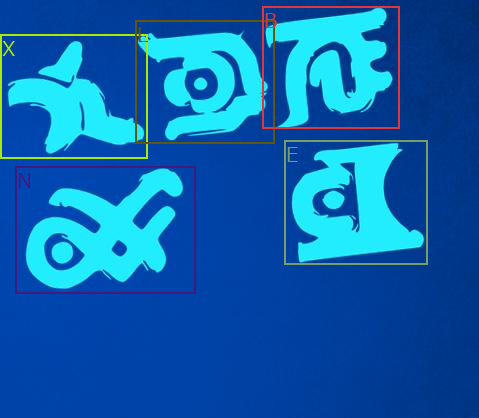

[[0, 34, 147, 158], [135, 20, 274, 143], [262, 6, 399, 128], [15, 166, 195, 293], [284, 140, 427, 264]]


In [30]:
with open('targets.json', 'r', encoding="utf-8") as f:
    image_nb = 10 #7 #23
    infos = json.load(f)
    test_img = Image.open(infos[image_nb]['image'])
    displayCoords(test_img, infos[image_nb]['boxes'], infos[image_nb]['labels'])
    print(infos[image_nb]['boxes'])